In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [3]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


In [4]:
def getFashionMNIST(batch_size = 320):
    fashionmnist_data = torchvision.datasets.FashionMNIST(download=True, root = 'data/fashionmnist', transform = 
                                                                                 transforms.Compose([transforms.Resize(32),
                                                                                 transforms.ToTensor(), 
                                                                                 transforms.Lambda(lambda x: x.repeat(1, 1, 1))
                                                                                 ]))
    train_loader = torch.utils.data.DataLoader(fashionmnist_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=16)
    return train_loader, train_loader



def getDataset(dataset = "MNIST", batch_size = 320):
    if(dataset == "MNIST"):
        train_loader, test_loader = getMNIST(batch_size)
        noChannels,dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "FashionMNIST"):
        train_loader, test_loader = getFashionMNIST(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "Cifar10"):
        train_loader, test_loader = getCifar10(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    elif(dataset == "cityscapes"):
        train_loader, test_loader = getcityscapes(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    else:
        return None, None, None, None, None    
        
    return train_loader, test_loader, noChannels, dx, dy

In [12]:
def ImageDistancesFromBarycenter_sliced(batch_x, input_barycenter, remaining_indices):
  wasserDistance = []
  distance_cum_index = np.array([])
  #Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
  #for j in range(batch_x.shape[0]):
  for j in remaining_indices:
    
    wassDistance = ot.sliced_wasserstein_distance(batch_x[j][0], input_barycenter, seed=0)  

    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)

    
    
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  #distance_cum_index gives wasserstein distances of all images from the input barycenter
  distance_cum_index = np.array(distance_cum_index)
  remaining_indices = distance_cum_index[:,1][4:]
  remaining_indices = remaining_indices.astype(int)
    
  #print(remaining_indices)

  f1 = batch_x[int(distance_cum_index[:,1][0])][0].cpu().detach().numpy()
  f2 = batch_x[int(distance_cum_index[:,1][1])][0].cpu().detach().numpy()
  f3 = batch_x[int(distance_cum_index[:,1][2])][0].cpu().detach().numpy()
  f4 = batch_x[int(distance_cum_index[:,1][3])][0].cpu().detach().numpy()  

  A = np.array([f1, f2, f3, f4])
  reg = 0.004
  weights = np.array((0.25, 0.25, 0.25, 0.25))
  next_barycenter = ot.bregman.convolutional_barycenter2d(A, reg, weights) 
  next_barycenter = torch.tensor(next_barycenter)
  next_barycenter = next_barycenter.type(torch.FloatTensor)

  return A, next_barycenter, remaining_indices

In [13]:
train_loader, test_loader, noChannels, dx, dy = getDataset("FashionMNIST")  # FashionMNIST , MNIST|

In [14]:
for inum, (batch_x, label) in enumerate(train_loader):
    break
    

Size of batch :  320
Iteration number :  1
Input barycenter : 


/tmp/ipykernel_29292/2941083762.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


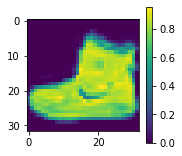

/tmp/ipykernel_29292/2941083762.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbours, bary, rem_indices = ImageDistancesFromBarycenter_sliced(batch_x, torch.tensor(bary), rem_indices)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2068: RuntimeWarning: overflow encountered in true_divide
  V = bar[None] / KU
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2074: RuntimeWarning: invalid value encountered in multiply
  err = (V * KU).std(axis=0).sum()
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2068: RuntimeWarning: divide by zero encountered in true_divide
  V = bar[None] / KU
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2088: UserWarning: Convolutional Sinkhorn did not converge. Try a larger number of

Neighbors of input barycenter :



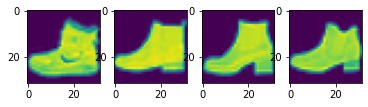

The new barycenter


/tmp/ipykernel_29292/2941083762.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


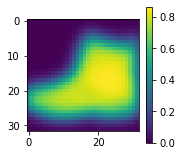

Tracking distance between new barycenter and previous barycenter :  tensor(0.1047)
torch.Size([32, 32])
Iteration number :  2
Input barycenter : 


/tmp/ipykernel_29292/2941083762.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bary = torch.tensor(bary)
/tmp/ipykernel_29292/2941083762.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)


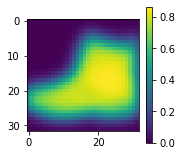

Neighbors of input barycenter :



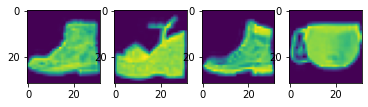

The new barycenter


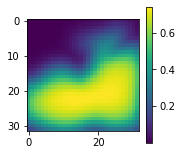

Tracking distance between new barycenter and previous barycenter :  tensor(0.1374)
torch.Size([64, 32])
Iteration number :  3
Input barycenter : 


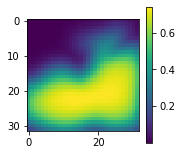

Neighbors of input barycenter :



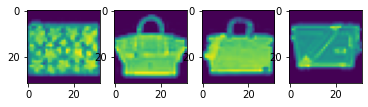

The new barycenter


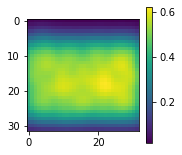

Tracking distance between new barycenter and previous barycenter :  tensor(0.1324)
torch.Size([96, 32])
Iteration number :  4
Input barycenter : 


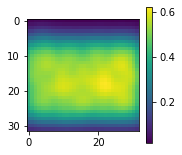

Neighbors of input barycenter :



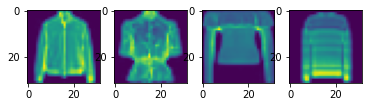

The new barycenter


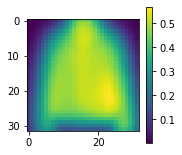

Tracking distance between new barycenter and previous barycenter :  tensor(0.1359)
torch.Size([128, 32])
Iteration number :  5
Input barycenter : 


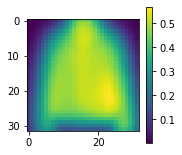

Neighbors of input barycenter :



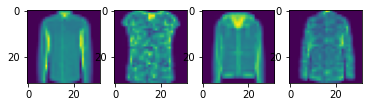

The new barycenter


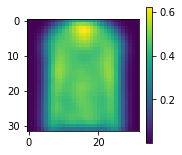

Tracking distance between new barycenter and previous barycenter :  tensor(0.0903)
Iteration number :  6
Input barycenter : 


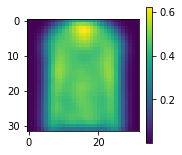

Neighbors of input barycenter :



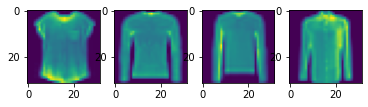

The new barycenter


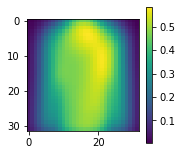

Tracking distance between new barycenter and previous barycenter :  tensor(0.0656)
Iteration number :  7
Input barycenter : 


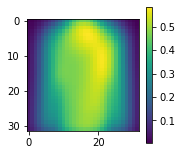

Neighbors of input barycenter :



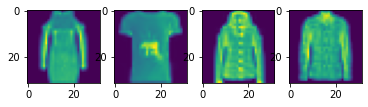

The new barycenter


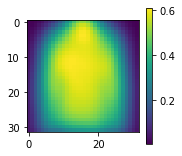

Tracking distance between new barycenter and previous barycenter :  tensor(0.0593)
Iteration number :  8
Input barycenter : 


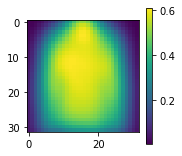

Neighbors of input barycenter :



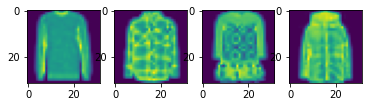

The new barycenter


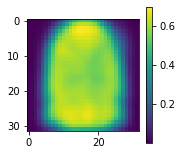

Tracking distance between new barycenter and previous barycenter :  tensor(0.0732)
Iteration number :  9
Input barycenter : 


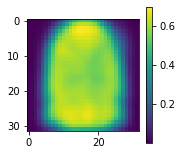

Neighbors of input barycenter :



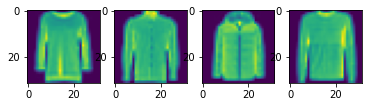

The new barycenter


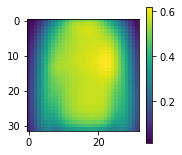

Tracking distance between new barycenter and previous barycenter :  tensor(0.0918)
Iteration number :  10
Input barycenter : 


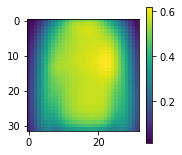

Neighbors of input barycenter :



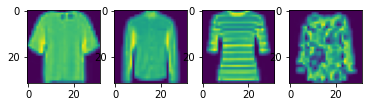

The new barycenter


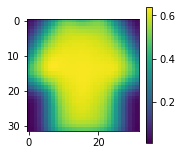

Tracking distance between new barycenter and previous barycenter :  tensor(0.0753)
Iteration number :  11
Input barycenter : 


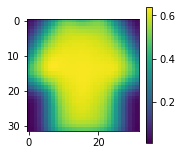

Neighbors of input barycenter :



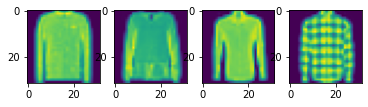

The new barycenter


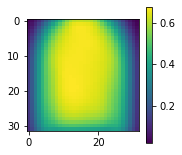

Tracking distance between new barycenter and previous barycenter :  tensor(0.0743)
Iteration number :  12
Input barycenter : 


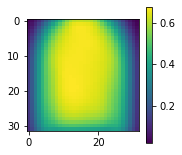

Neighbors of input barycenter :



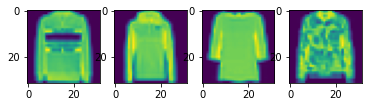

The new barycenter


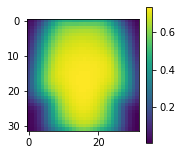

Tracking distance between new barycenter and previous barycenter :  tensor(0.0564)
Iteration number :  13
Input barycenter : 


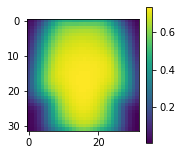

Neighbors of input barycenter :



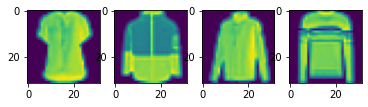

The new barycenter


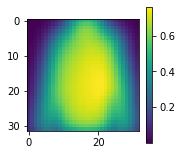

Tracking distance between new barycenter and previous barycenter :  tensor(0.0909)
Iteration number :  14
Input barycenter : 


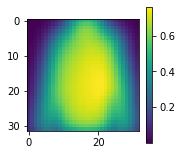

Neighbors of input barycenter :



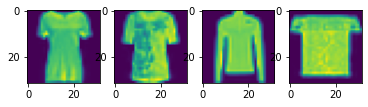

The new barycenter


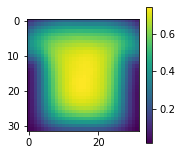

Tracking distance between new barycenter and previous barycenter :  tensor(0.0875)
Iteration number :  15
Input barycenter : 


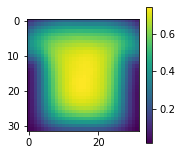

Neighbors of input barycenter :



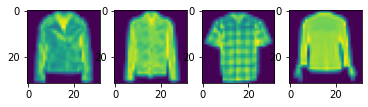

The new barycenter


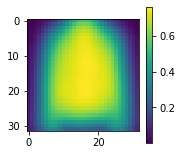

Tracking distance between new barycenter and previous barycenter :  tensor(0.0559)
Iteration number :  16
Input barycenter : 


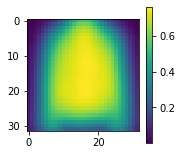

Neighbors of input barycenter :



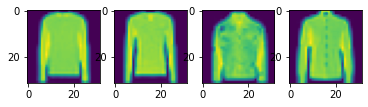

The new barycenter


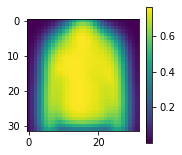

Tracking distance between new barycenter and previous barycenter :  tensor(0.0653)
Iteration number :  17
Input barycenter : 


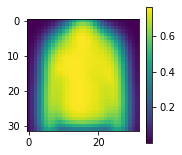

Neighbors of input barycenter :



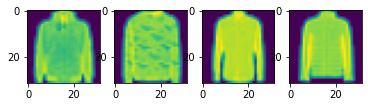

The new barycenter


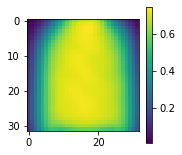

Tracking distance between new barycenter and previous barycenter :  tensor(0.1105)
torch.Size([160, 32])
Iteration number :  18
Input barycenter : 


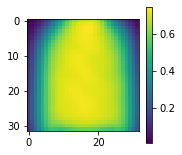

Neighbors of input barycenter :



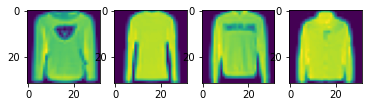

The new barycenter


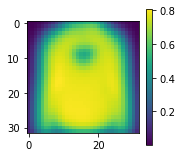

Tracking distance between new barycenter and previous barycenter :  tensor(0.0866)
Iteration number :  19
Input barycenter : 


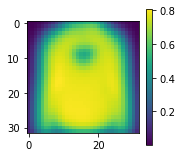

Neighbors of input barycenter :



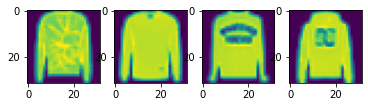

The new barycenter


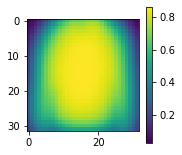

Tracking distance between new barycenter and previous barycenter :  tensor(0.0993)
Iteration number :  20
Input barycenter : 


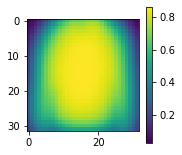

Neighbors of input barycenter :



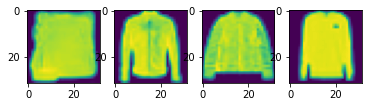

The new barycenter


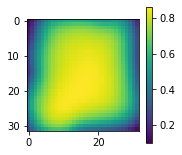

Tracking distance between new barycenter and previous barycenter :  tensor(0.0703)
Iteration number :  21
Input barycenter : 


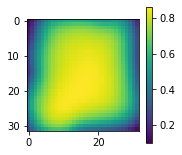

Neighbors of input barycenter :



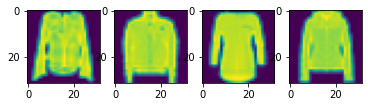

The new barycenter


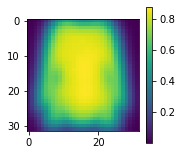

Tracking distance between new barycenter and previous barycenter :  tensor(0.1731)
torch.Size([192, 32])
Iteration number :  22
Input barycenter : 


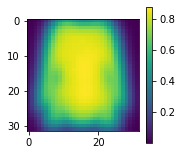

Neighbors of input barycenter :



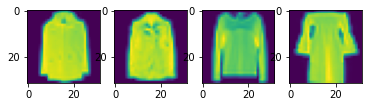

The new barycenter


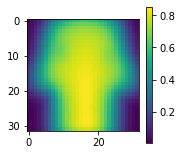

Tracking distance between new barycenter and previous barycenter :  tensor(0.1014)
torch.Size([224, 32])
Iteration number :  23
Input barycenter : 


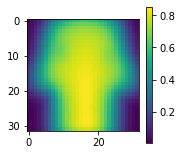

Neighbors of input barycenter :



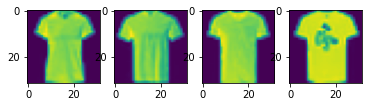

The new barycenter


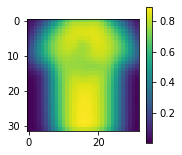

Tracking distance between new barycenter and previous barycenter :  tensor(0.0578)
Iteration number :  24
Input barycenter : 


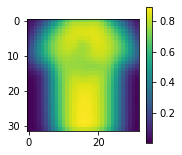

Neighbors of input barycenter :



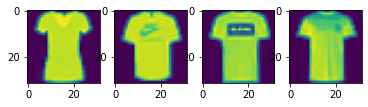

The new barycenter


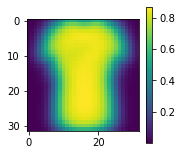

Tracking distance between new barycenter and previous barycenter :  tensor(0.1123)
torch.Size([256, 32])
Iteration number :  25
Input barycenter : 


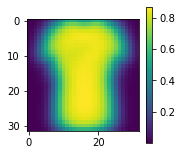

Neighbors of input barycenter :



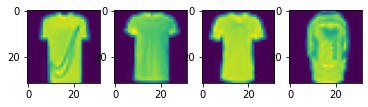

The new barycenter


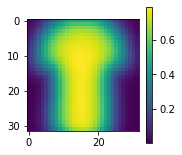

Tracking distance between new barycenter and previous barycenter :  tensor(0.1019)
torch.Size([288, 32])
Iteration number :  26
Input barycenter : 


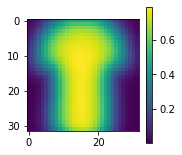

Neighbors of input barycenter :



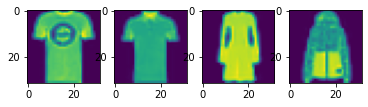

The new barycenter


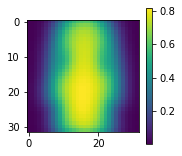

Tracking distance between new barycenter and previous barycenter :  tensor(0.0690)
Iteration number :  27
Input barycenter : 


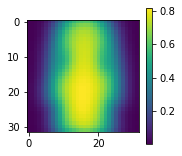

Neighbors of input barycenter :



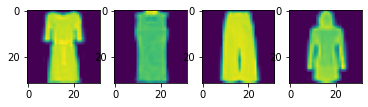

The new barycenter


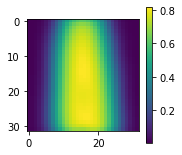

Tracking distance between new barycenter and previous barycenter :  tensor(0.0322)
Iteration number :  28
Input barycenter : 


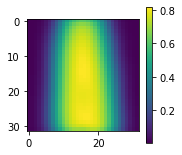

Neighbors of input barycenter :



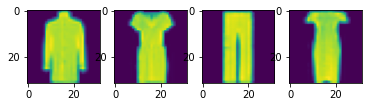

The new barycenter


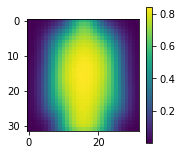

Tracking distance between new barycenter and previous barycenter :  tensor(0.0705)
Iteration number :  29
Input barycenter : 


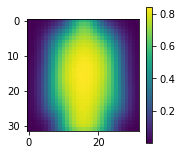

Neighbors of input barycenter :



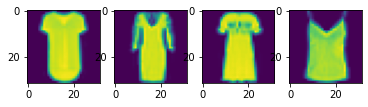

The new barycenter


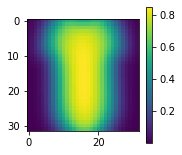

Tracking distance between new barycenter and previous barycenter :  tensor(0.0619)
Iteration number :  30
Input barycenter : 


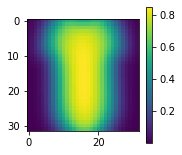

Neighbors of input barycenter :



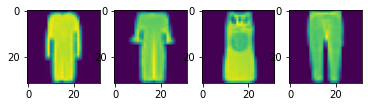

The new barycenter


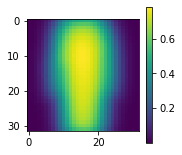

Tracking distance between new barycenter and previous barycenter :  tensor(0.1006)
torch.Size([320, 32])
Iteration number :  31
Input barycenter : 


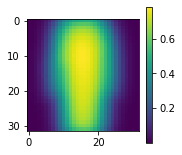

Neighbors of input barycenter :



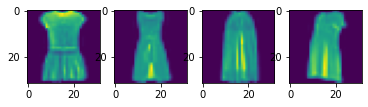

The new barycenter


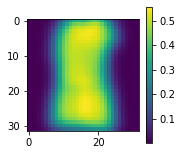

Tracking distance between new barycenter and previous barycenter :  tensor(0.1271)
torch.Size([352, 32])
Iteration number :  32
Input barycenter : 


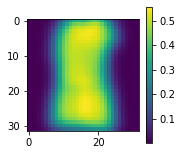

Neighbors of input barycenter :



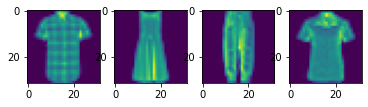

The new barycenter


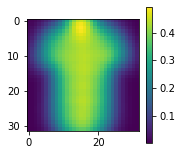

Tracking distance between new barycenter and previous barycenter :  tensor(0.0722)
Iteration number :  33
Input barycenter : 


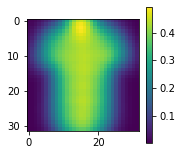

Neighbors of input barycenter :



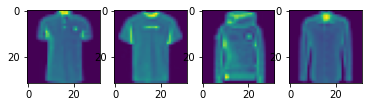

The new barycenter


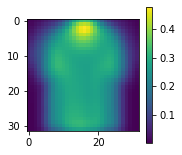

Tracking distance between new barycenter and previous barycenter :  tensor(0.0703)
Iteration number :  34
Input barycenter : 


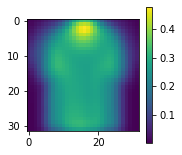

Neighbors of input barycenter :



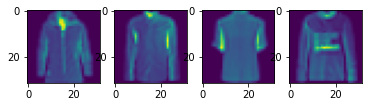

The new barycenter


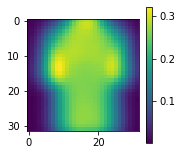

Tracking distance between new barycenter and previous barycenter :  tensor(0.0371)
Iteration number :  35
Input barycenter : 


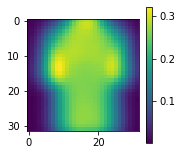

Neighbors of input barycenter :



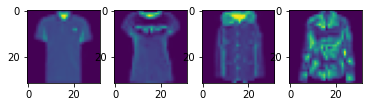

The new barycenter


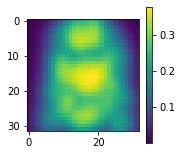

Tracking distance between new barycenter and previous barycenter :  tensor(0.0377)
Iteration number :  36
Input barycenter : 


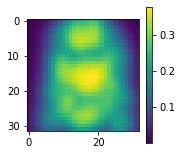

Neighbors of input barycenter :



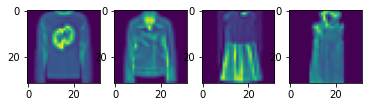

The new barycenter


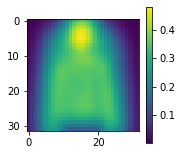

Tracking distance between new barycenter and previous barycenter :  tensor(0.0557)
Iteration number :  37
Input barycenter : 


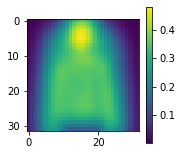

Neighbors of input barycenter :



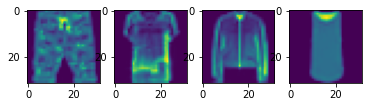

The new barycenter


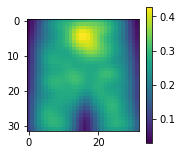

Tracking distance between new barycenter and previous barycenter :  tensor(0.0594)
Iteration number :  38
Input barycenter : 


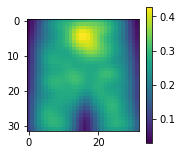

Neighbors of input barycenter :



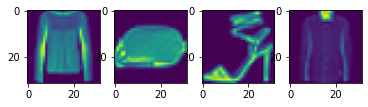

The new barycenter


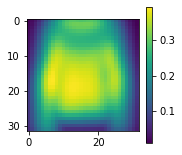

Tracking distance between new barycenter and previous barycenter :  tensor(0.0545)
Iteration number :  39
Input barycenter : 


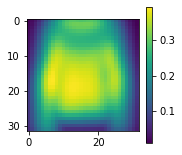

Neighbors of input barycenter :



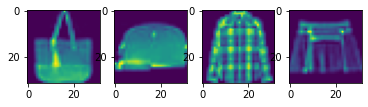

The new barycenter


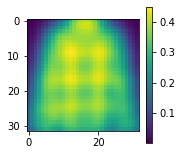

Tracking distance between new barycenter and previous barycenter :  tensor(0.0735)
Iteration number :  40
Input barycenter : 


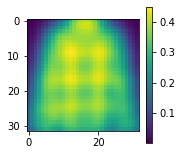

Neighbors of input barycenter :



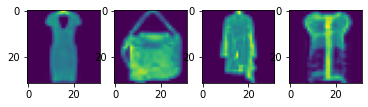

The new barycenter


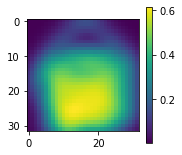

Tracking distance between new barycenter and previous barycenter :  tensor(0.1254)
torch.Size([384, 32])
Iteration number :  41
Input barycenter : 


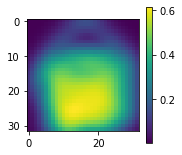

Neighbors of input barycenter :



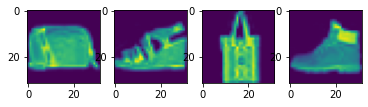

The new barycenter


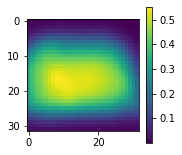

Tracking distance between new barycenter and previous barycenter :  tensor(0.1100)
torch.Size([416, 32])
Iteration number :  42
Input barycenter : 


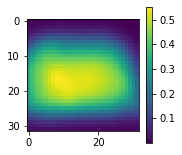

Neighbors of input barycenter :



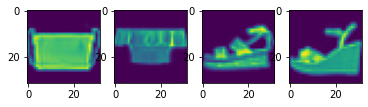

The new barycenter


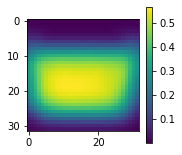

Tracking distance between new barycenter and previous barycenter :  tensor(0.0413)
Iteration number :  43
Input barycenter : 


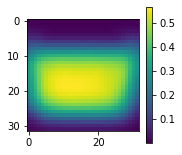

Neighbors of input barycenter :



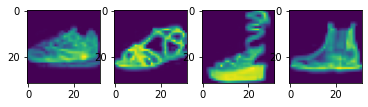

The new barycenter


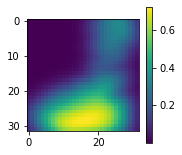

Tracking distance between new barycenter and previous barycenter :  tensor(0.1454)
torch.Size([448, 32])
Iteration number :  44
Input barycenter : 


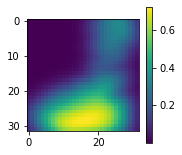

Neighbors of input barycenter :



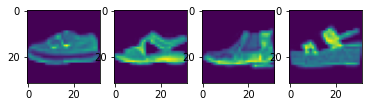

The new barycenter


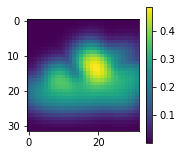

Tracking distance between new barycenter and previous barycenter :  tensor(0.1451)
torch.Size([480, 32])
Iteration number :  45
Input barycenter : 


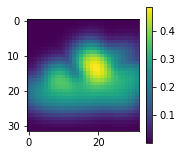

Neighbors of input barycenter :



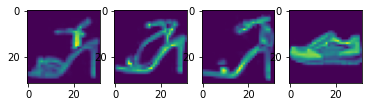

The new barycenter


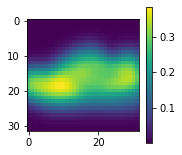

Tracking distance between new barycenter and previous barycenter :  tensor(0.0584)
Iteration number :  46
Input barycenter : 


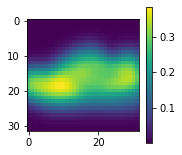

Neighbors of input barycenter :



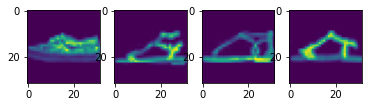

The new barycenter


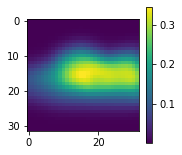

Tracking distance between new barycenter and previous barycenter :  tensor(0.0534)
Iteration number :  47
Input barycenter : 


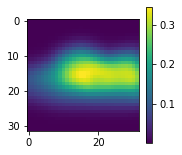

Neighbors of input barycenter :



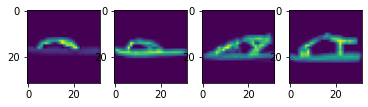

The new barycenter


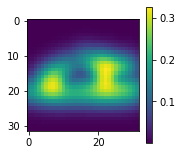

Tracking distance between new barycenter and previous barycenter :  tensor(0.0558)
Iteration number :  48
Input barycenter : 


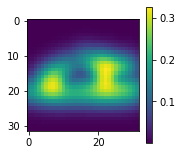

Neighbors of input barycenter :



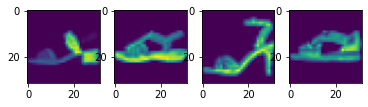

The new barycenter


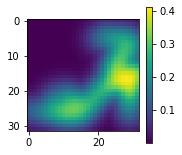

Tracking distance between new barycenter and previous barycenter :  tensor(0.0854)
Iteration number :  49
Input barycenter : 


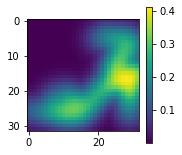

Neighbors of input barycenter :



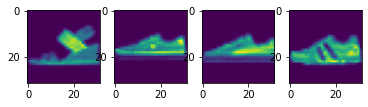

The new barycenter


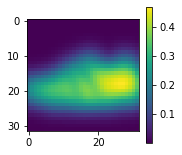

Tracking distance between new barycenter and previous barycenter :  tensor(0.0976)
Iteration number :  50
Input barycenter : 


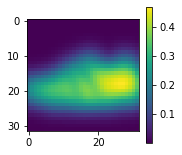

Neighbors of input barycenter :



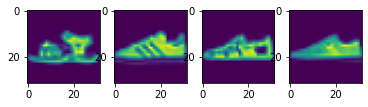

The new barycenter


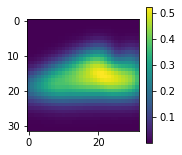

Tracking distance between new barycenter and previous barycenter :  tensor(0.0309)
Iteration number :  51
Input barycenter : 


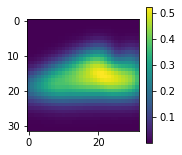

Neighbors of input barycenter :



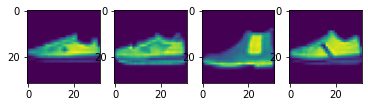

The new barycenter


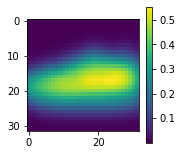

Tracking distance between new barycenter and previous barycenter :  tensor(0.0455)
Iteration number :  52
Input barycenter : 


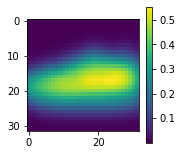

Neighbors of input barycenter :



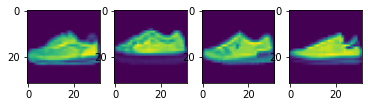

The new barycenter


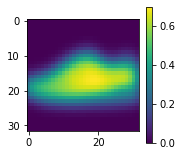

Tracking distance between new barycenter and previous barycenter :  tensor(0.0718)
Iteration number :  53
Input barycenter : 


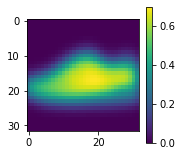

Neighbors of input barycenter :



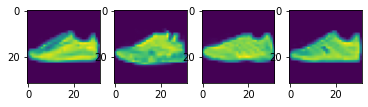

The new barycenter


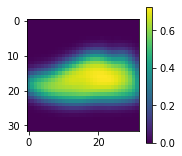

Tracking distance between new barycenter and previous barycenter :  tensor(0.0507)
Iteration number :  54
Input barycenter : 


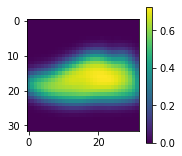

Neighbors of input barycenter :



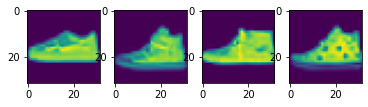

The new barycenter


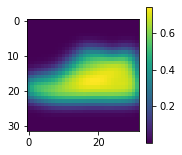

Tracking distance between new barycenter and previous barycenter :  tensor(0.0477)
Iteration number :  55
Input barycenter : 


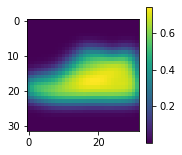

Neighbors of input barycenter :



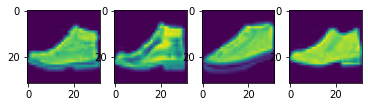

The new barycenter


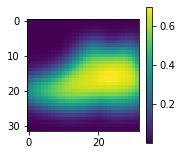

Tracking distance between new barycenter and previous barycenter :  tensor(0.0640)
Iteration number :  56
Input barycenter : 


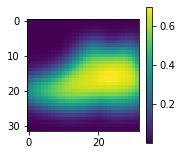

Neighbors of input barycenter :



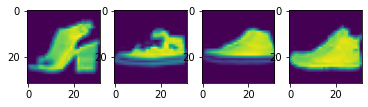

The new barycenter


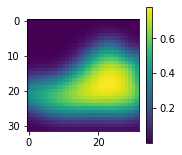

Tracking distance between new barycenter and previous barycenter :  tensor(0.0534)
Iteration number :  57
Input barycenter : 


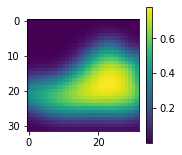

Neighbors of input barycenter :



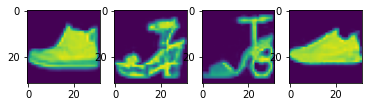

The new barycenter


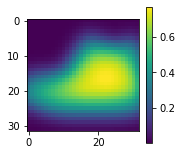

Tracking distance between new barycenter and previous barycenter :  tensor(0.0360)
Iteration number :  58
Input barycenter : 


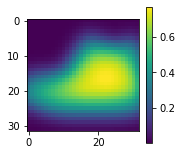

Neighbors of input barycenter :



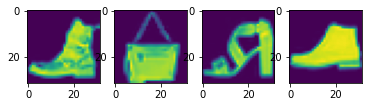

The new barycenter


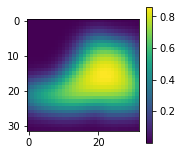

Tracking distance between new barycenter and previous barycenter :  tensor(0.0582)
Iteration number :  59
Input barycenter : 


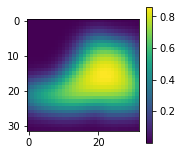

Neighbors of input barycenter :



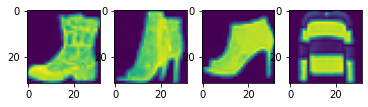

The new barycenter


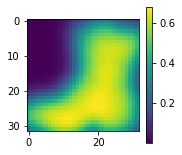

Tracking distance between new barycenter and previous barycenter :  tensor(0.1788)
torch.Size([512, 32])
Iteration number :  60
Input barycenter : 


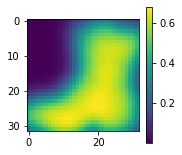

Neighbors of input barycenter :



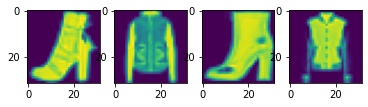

The new barycenter


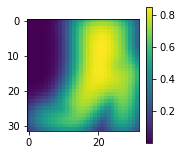

Tracking distance between new barycenter and previous barycenter :  tensor(0.1671)
torch.Size([544, 32])
Iteration number :  61
Input barycenter : 


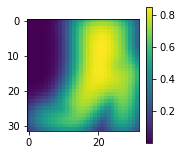

Neighbors of input barycenter :



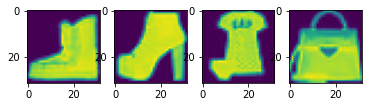

The new barycenter


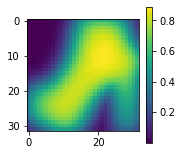

Tracking distance between new barycenter and previous barycenter :  tensor(0.1656)
torch.Size([576, 32])
Iteration number :  62
Input barycenter : 


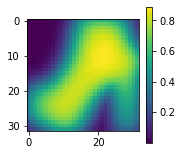

Neighbors of input barycenter :



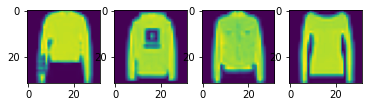

The new barycenter


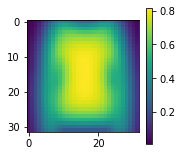

Tracking distance between new barycenter and previous barycenter :  tensor(0.2083)
torch.Size([608, 32])
Iteration number :  63
Input barycenter : 


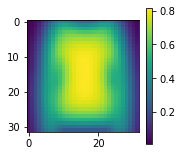

Neighbors of input barycenter :



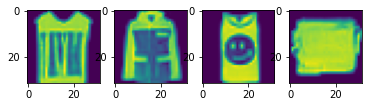

The new barycenter


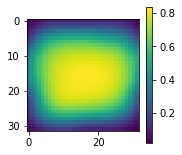

Tracking distance between new barycenter and previous barycenter :  tensor(0.1551)
torch.Size([640, 32])
Iteration number :  64
Input barycenter : 


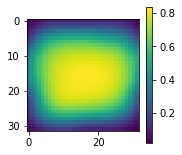

Neighbors of input barycenter :



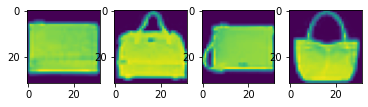

The new barycenter


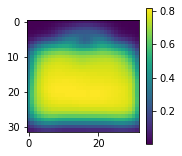

Tracking distance between new barycenter and previous barycenter :  tensor(0.0745)
Iteration number :  65
Input barycenter : 


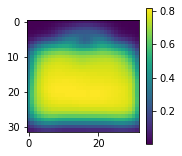

Neighbors of input barycenter :



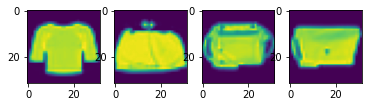

The new barycenter


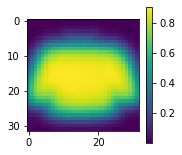

Tracking distance between new barycenter and previous barycenter :  tensor(0.1163)
torch.Size([672, 32])
Iteration number :  66
Input barycenter : 


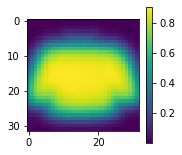

Neighbors of input barycenter :



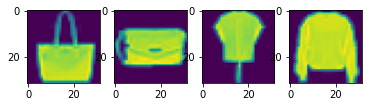

The new barycenter


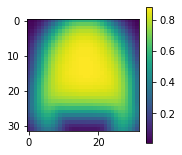

Tracking distance between new barycenter and previous barycenter :  tensor(0.2365)
torch.Size([704, 32])
Iteration number :  67
Input barycenter : 


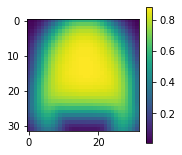

Neighbors of input barycenter :



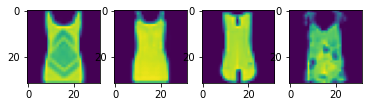

The new barycenter


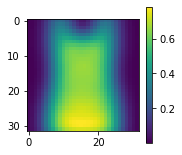

Tracking distance between new barycenter and previous barycenter :  tensor(0.2904)
torch.Size([736, 32])
Iteration number :  68
Input barycenter : 


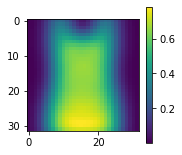

Neighbors of input barycenter :



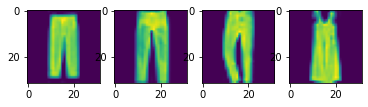

The new barycenter


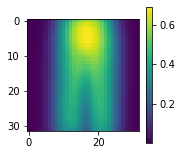

Tracking distance between new barycenter and previous barycenter :  tensor(0.1256)
torch.Size([768, 32])
Iteration number :  69
Input barycenter : 


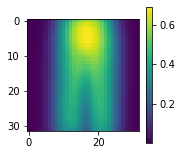

Neighbors of input barycenter :



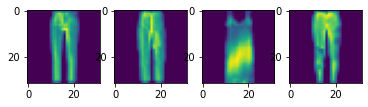

The new barycenter


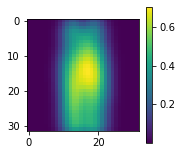

Tracking distance between new barycenter and previous barycenter :  tensor(0.1193)
torch.Size([800, 32])
Iteration number :  70
Input barycenter : 


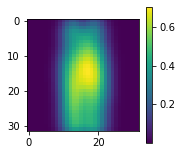

Neighbors of input barycenter :



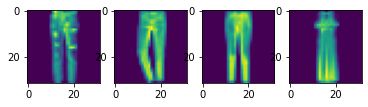

The new barycenter


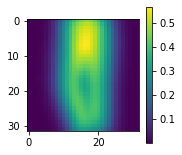

Tracking distance between new barycenter and previous barycenter :  tensor(0.0611)
Iteration number :  71
Input barycenter : 


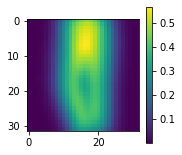

Neighbors of input barycenter :



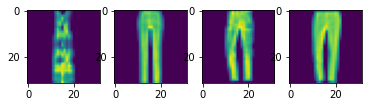

The new barycenter


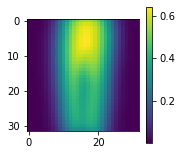

Tracking distance between new barycenter and previous barycenter :  tensor(0.0485)
Iteration number :  72
Input barycenter : 


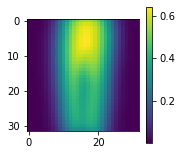

Neighbors of input barycenter :



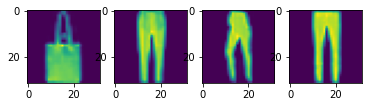

The new barycenter


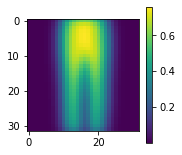

Tracking distance between new barycenter and previous barycenter :  tensor(0.0564)
Iteration number :  73
Input barycenter : 


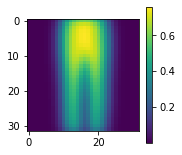

Neighbors of input barycenter :



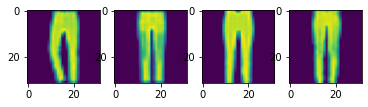

The new barycenter


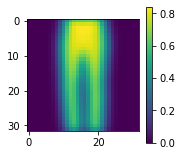

Tracking distance between new barycenter and previous barycenter :  tensor(0.0598)
Iteration number :  74
Input barycenter : 


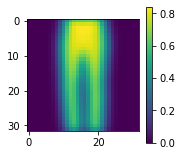

Neighbors of input barycenter :



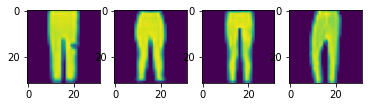

The new barycenter


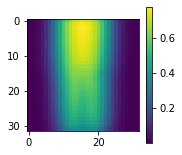

Tracking distance between new barycenter and previous barycenter :  tensor(0.0880)
Iteration number :  75
Input barycenter : 


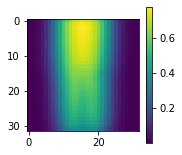

Neighbors of input barycenter :



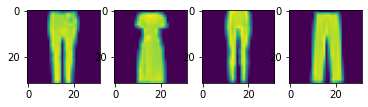

The new barycenter


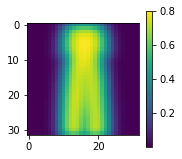

Tracking distance between new barycenter and previous barycenter :  tensor(0.0879)
Iteration number :  76
Input barycenter : 


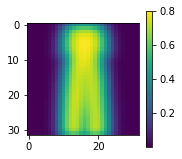

Neighbors of input barycenter :



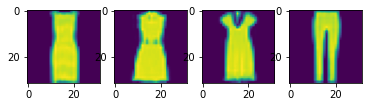

The new barycenter


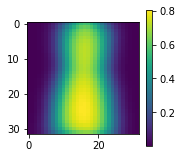

Tracking distance between new barycenter and previous barycenter :  tensor(0.0667)
Iteration number :  77
Input barycenter : 


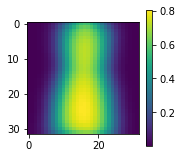

Neighbors of input barycenter :



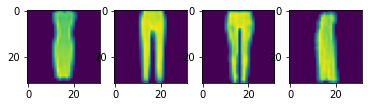

The new barycenter


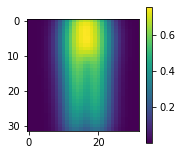

Tracking distance between new barycenter and previous barycenter :  tensor(0.1132)
torch.Size([832, 32])
Iteration number :  78
Input barycenter : 


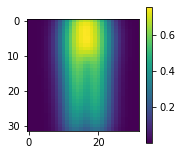

Neighbors of input barycenter :



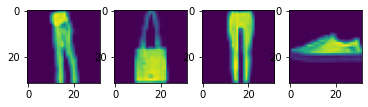

The new barycenter


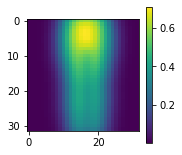

Tracking distance between new barycenter and previous barycenter :  tensor(0.0456)
Iteration number :  79
Input barycenter : 


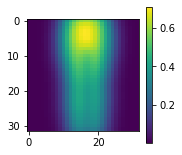

Neighbors of input barycenter :



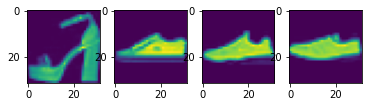

The new barycenter


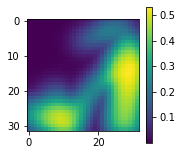

Tracking distance between new barycenter and previous barycenter :  tensor(0.2232)
torch.Size([864, 32])
Iteration number :  80
Input barycenter : 


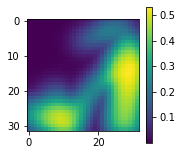

Neighbors of input barycenter :



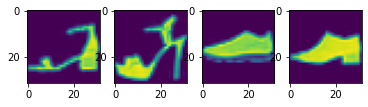

The new barycenter


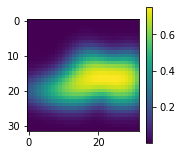

Tracking distance between new barycenter and previous barycenter :  tensor(0.1933)
torch.Size([896, 32])


In [15]:
bary = batch_x[0][0]
rem_indices = np.array(range(0,batch_x.shape[0]))
#Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
print("Size of batch : ", batch_x.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
for i in range(int(batch_x.shape[0]/4)):
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    
    old_bary = bary

    neighbours, bary, rem_indices = ImageDistancesFromBarycenter_sliced(batch_x, torch.tensor(bary), rem_indices)
    

    print("Neighbors of input barycenter :")
    print()
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(torch.tensor(neighbours[0]).view(32,32))
    axarr[1].imshow(torch.tensor(neighbours[1]).view(32,32))
    axarr[2].imshow(torch.tensor(neighbours[2]).view(32,32))
    axarr[3].imshow(torch.tensor(neighbours[3]).view(32,32))
    plt.show()

    print("The new barycenter")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    

    bary = torch.tensor(bary)

    wassDistance = ot.sliced_wasserstein_distance(old_bary, bary, seed=0)  
    
    
    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance >= 0.1):
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)
        print(sampled_barycenters.shape)
sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]*sampled_barycenters.shape[1])/1024), 32, 32)


In [16]:
sampled_barycenters.shape

torch.Size([28, 32, 32])

/tmp/ipykernel_29292/2811262560.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(sampled_barycenters[i]).view(32,32))


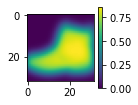

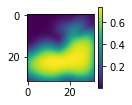

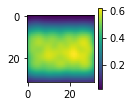

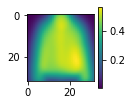

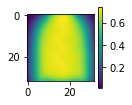

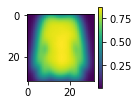

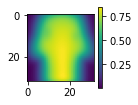

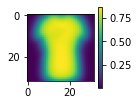

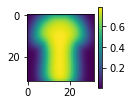

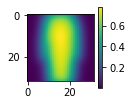

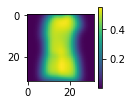

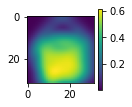

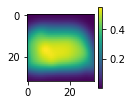

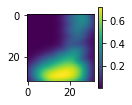

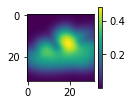

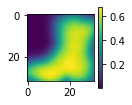

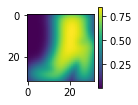

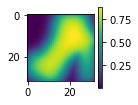

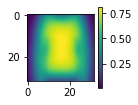

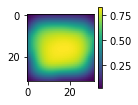

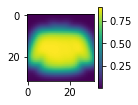

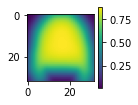

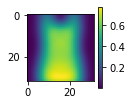

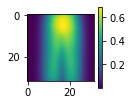

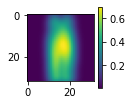

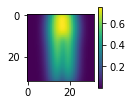

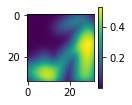

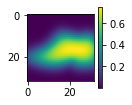

In [17]:
# printing all sampled barycenters
for i in range(sampled_barycenters.shape[0]):    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(torch.tensor(sampled_barycenters[i]).view(32,32))
    plt.colorbar()
    plt.show()

In [19]:
wass_dist_matrix = np.zeros((sampled_barycenters.shape[0], sampled_barycenters.shape[0]))
for i in range(sampled_barycenters.shape[0]):
    for j in range(sampled_barycenters.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            wassDistance = ot.sliced_wasserstein_distance(sampled_barycenters[i], sampled_barycenters[j], seed=0)  

            wass_dist_matrix[j, i] = wassDistance


In [20]:
wass_dist_matrix.shape

(28, 28)

In [21]:
wass_dist_matrix.shape #.cpu().detach().numpy()

(28, 28)

In [22]:
diagrams = ripser.ripser(wass_dist_matrix, distance_matrix=True, maxdim=4)['dgms']


In [23]:
diagrams

[array([[0.        , 0.0506573 ],
        [0.        , 0.05870473],
        [0.        , 0.06077402],
        [0.        , 0.07679302],
        [0.        , 0.08763009],
        [0.        , 0.08772305],
        [0.        , 0.0878145 ],
        [0.        , 0.08856333],
        [0.        , 0.08959509],
        [0.        , 0.0968825 ],
        [0.        , 0.09696257],
        [0.        , 0.09810179],
        [0.        , 0.10428955],
        [0.        , 0.10541105],
        [0.        , 0.1138293 ],
        [0.        , 0.11581784],
        [0.        , 0.12189727],
        [0.        , 0.12289698],
        [0.        , 0.1244476 ],
        [0.        , 0.12467184],
        [0.        , 0.12574948],
        [0.        , 0.12603067],
        [0.        , 0.12794802],
        [0.        , 0.13237996],
        [0.        , 0.13468829],
        [0.        , 0.1399789 ],
        [0.        , 0.1494938 ],
        [0.        ,        inf]]),
 array([[0.17773238, 0.18850091],
        [0.1

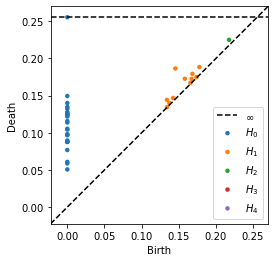

In [24]:
plot_diagrams(diagrams, show=True)

In [25]:
# Persistent homology calculation using l2 distance between barycenters

In [26]:
dist_mat_FMNIST = _compute_distance_matrix(sampled_barycenters, p=2)

/tmp/ipykernel_29292/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


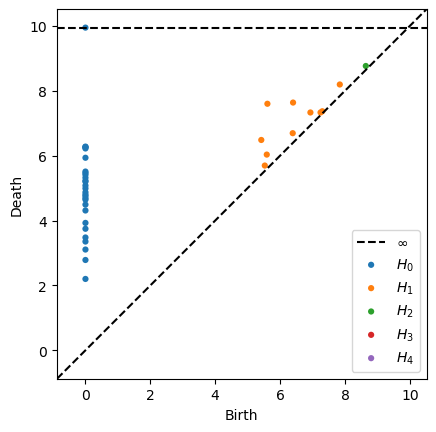

In [27]:
_, PH_diagram_barycenters = get_persistence_diagram(sampled_barycenters, 4)